Overlay scores on heatmaps

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image
import matplotlib.pyplot as plt

In [260]:
results_dir = "image_sets/results_2/exp_10_s1/"

Plotly overlay

In [261]:
import plotly.figure_factory as ff

plt.text overlay

In [262]:
patch_folder = "image_sets/patches/F005a02/"

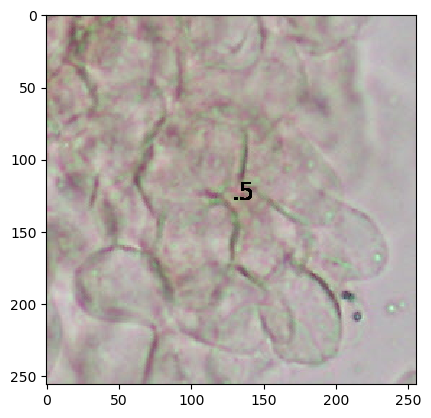

In [263]:
for patch_file in sorted(os.listdir(patch_folder)):
    img_path = os.path.join(patch_folder, patch_file)
    img = Image.open(img_path)
    plt.text(128, 128, r'.5',fontsize='xx-large')
    plt.imshow(img)

Check .pt files shape

In [264]:
import torch

In [265]:
filePath = "image_sets/patches/fungal_vs_nonfungal_resnet_features/pt_files/N009a003.pt"
a = torch.load(filePath)

In [266]:
print(a.shape)

torch.Size([24, 1, 1, 1024])


patch annotations

In [45]:
import os
import argparse
import yaml
import cv2
import numpy as np
from PIL import Image
from itertools import product
import matplotlib.pyplot as plt

from sklearn.datasets import load_sample_image
from sklearn.feature_extraction import image

In [60]:
filename = "F030a11.tif"
dir_in = "image_sets/original/"
patch_dir = "image_sets/patches_annotated/"
threshold = 35
d = 256 # patch size

[771, 300, 837, 10872, 4017, 1158, 816, 297, 363, 366, 951, 357, 2043, 1173, 2574, 1725, 2034, 1002, 3693, 3624, 4239, 2469, 3948, 3144]


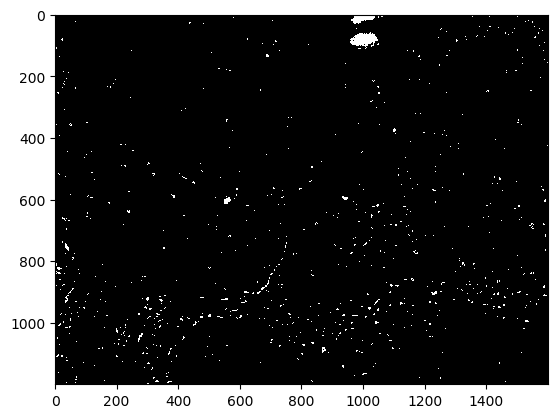

In [61]:
patch_scores = []
name, ext = os.path.splitext(filename)
dir_out = os.path.join(patch_dir, name)
img_cv = cv2.imread(os.path.join(dir_in, filename))
img_cv_gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
ret, img_cv_binarized = cv2.threshold(img_cv_gray, threshold, 255, cv2.THRESH_BINARY_INV)  # Apply thresholding
img_pil_binarized = cv2.cvtColor(img_cv_binarized, cv2.COLOR_BGR2RGB)  # Convert to RGB, for PIL Image
img_pil_binarized = Image.fromarray(img_pil_binarized)  # Convert to PIL Image
w, h = img_pil_binarized.size

grid = product(range(0, h-h%d, d), range(0, w-w%d, d))
for i, j in grid:
    box = (j, i, j+d, i+d)
    i /= 256
    j /= 256
    out = os.path.join(dir_out, f'{name}_{int(i)}_{int(j)}{ext}')

    img_patch = img_pil_binarized.crop(box)

    img_patch_np = np.asarray(img_patch)  # Convert to Numpy array
    patch_non_zero = np.count_nonzero(img_patch_np)
    patch_scores.append(patch_non_zero)

    # img_patch.save(out)  # Save patch image    

plt.imshow(img_pil_binarized)
print(patch_scores)

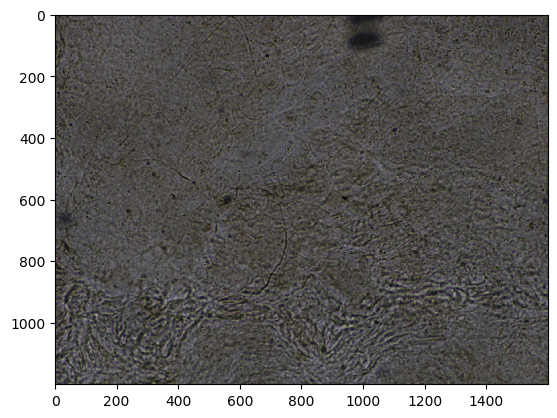

In [62]:
plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))

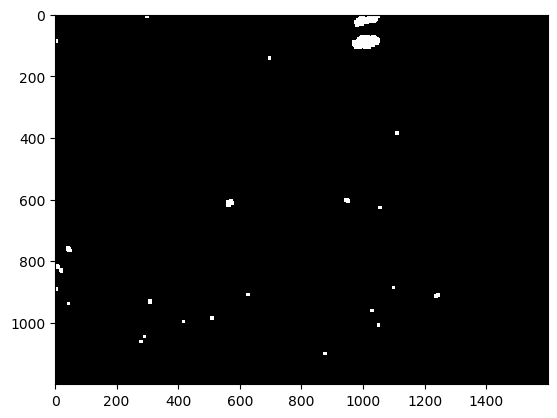

In [63]:
kernel = np.ones((2, 2), np.uint8)
img_cv_eroded = cv2.erode(img_cv_binarized.copy(), kernel, iterations=5)
img_cv_dilated = cv2.dilate(img_cv_eroded.copy(), kernel, iterations=10)
img_cv_dilated = cv2.cvtColor(img_cv_dilated, cv2.COLOR_BGR2RGB)
plt.imshow(img_cv_dilated, cmap='gray')

In [64]:
# cv2.blur(img_cv_eroded, ())

In [51]:
print(img_cv_dilated.shape)
print(img_cv_gray.shape)

(1200, 1600, 3)
(1200, 1600)


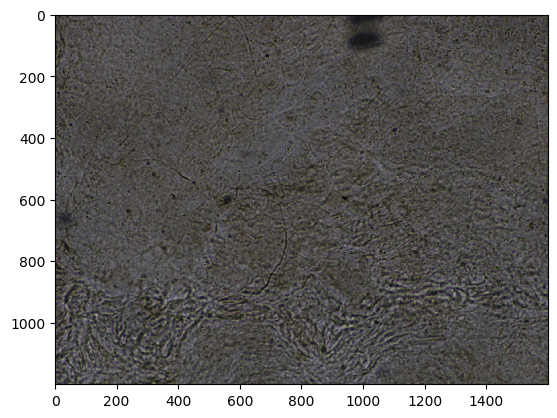

In [52]:
# new = cv2.addWeighted(img_cv_gray, 1, img_cv_eroded, 2, 0)
new = cv2.add(img_cv, img_cv_dilated)
plt.imshow(cv2.cvtColor(new, cv2.COLOR_BGR2RGB))

Patch threshold

In [5]:
import os
import argparse
import yaml
import cv2
import numpy as np
from PIL import Image
from itertools import product
import matplotlib.pyplot as plt
from utils.file_utils import save_pkl, load_pkl

from sklearn.datasets import load_sample_image
from sklearn.feature_extraction import image

In [17]:
filename = "F005a02.tif"
dir_in = "image_sets/annotated/"
patch_dir = "image_sets/patches_annotated/"
threshold = 2500
d = 256 # patch size

In [18]:
name, ext = os.path.splitext(filename)
dir_out = os.path.join(patch_dir, name)

In [19]:
img_scores = load_pkl(os.path.join(dir_out, name+".pkl"))
print(img_scores)

{'patch_scores': [7032, 10353, 7677, 3762, 5256, 0, 279, 3897, 13623, 2697, 1800, 0, 0, 3981, 5706, 7824, 90, 0, 7494, 4839, 4695, 1200, 0, 0], 'bin_scores': [False, True, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]}


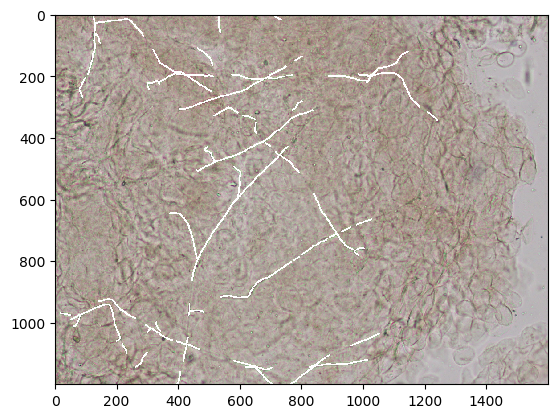

In [20]:
orig_img = Image.open(os.path.join(dir_in, filename))
plt.imshow(orig_img)

Annot splits

In [29]:
import random
random.seed(1)

In [30]:
a = ['N001a001', 'N001a002', 'N003a001', 'N003a002', 'N004a005', 'N004a006', 'N004a008', 'N004a009', 'N004a010', 'N004a011', 'N004a013', 'N004a017', 'N004a018', 'N004a020', 'N004a021', 'N004a022', 'N004a023', 'N004a024', 'N004a025', 'N004a026', 'N004a028', 'N004a032', 'N004a036', 'N004a037', 'N004a038', 'N004a039', 'N004a041', 'N004a042', 'N004a043', 'N004a044', 'N004a045', 'N004a046', 'N004a048', 'N004a049', 'N004a050', 'N004a051', 'N004a052', 'N004a053', 'N004a054', 'N004a059', 'N004a060', 'N004a061', 'N004a062', 'N004a064', 'N004a066', 'N004a067', 'N004a068', 'N004a071', 'N004a072', 'N004a073', 'N004a074', 'N004a075', 'N004a076', 'N004a077', 'N004a078', 'N004a079', 'N004a081', 'N004a082', 'N004a083', 'N004a084', 'N004a085', 'N004a087', 'N004a088', 'N004a091', 'N004a092', 'N004a094', 'N004a095', 'N004a096', 'N004a097', 'N004a098', 'N004a099', 'N004a100', 'N004a101', 'N004a105', 'N004a106', 'N004a109', 'N004a110', 'N004a111', 'N004a112', 'N004a113', 'N004a115', 'N004a116', 'N004a117', 'N004a120', 'N004a121', 'N004a123', 'N004a124', 'N004a125', 'N004a127', 'N004a128', 'N004a129', 'N004a130', 'N004a131', 'N004a132', 'N004a133', 'N004a134', 'N004a135', 'N004a136', 'N005a001', 'N005a002', 'N005a003', 'N005a005', 'N005a006', 'N005a007', 'N005a009', 'N005a012', 'N005a013', 'N005a015', 'N005a016', 'N005a018', 'N005a019', 'N005a021', 'N005a022', 'N005a023', 'N006a001', 'N006a002', 'N006a004', 'N006a005', 'N006a007', 'N006a008', 'N006a009', 'N006a010', 'N007a001', 'N007a002', 'N007a003', 'N007a004', 'N009a001', 'N009a002', 'N009a005', 'N009a006', 'N011a001', 'N011a002', 'N011a003', 'N011a005', 'N011a006', 'N011a007', 'N011a008', 'N011a009', 'N011a010', 'N012a002', 'N012a003', 'N012a004', 'N012a008', 'N012a009', 'N012a010', 'N012a013', 'N012a016', 'N012a017', 'N012a019', 'N012a020', 'N017a001', 'F005a02', 'F006a01', 'F030a13', 'F030a14', 'F030a15', 'F030a17', 'F033a01','F033a02', 'F033a03', 'F033a04', 'F033a07', 'F033a09', 'F033a10', 'F033a11', 'F033a12', 'F033a15', 'F033a19', 'F033a20', 'F033a22', 'F033a23', 'F033a24', 'F033a25', 'F033a26', 'F033a27', 'F033a28', 'F033a29', 'F034a05', 'F034a06', 'F034a08', 'F034a09', 'F034a10', 'F034a11', 'F007a04', 'F048a02', 'F050a01', 'F050a03', 'F052a01', 'F052a03', 'F052a04', 'F052a05', 'F007a05', 'F052a06', 'F052a09', 'F052a10', 'F052a11', 'F052a12', 'F007a06', 'F052a16', 'F052a17', 'F052a18', 'F052a19', 'F052a20', 'F053a01', 'F053a02', 'F053a03', 'F053a04', 'F053a06', 'F053a07', 'F053a09', 'F053a10', 'F053a11', 'F053a12', 'F053a13', 'F053a14', 'F053a16', 'F053a18', 'F056a01', 'F056a05', 'F056a06', 'F056a07', 'F056a08', 'F056a09', 'F056a10', 'F056a11', 'F056a12', 'F056a13', 'F056a15', 'F057a01', 'F058a01', 'F058a02', 'F058a04', 'F058a05', 'F007a11', 'F007a12', 'F007a13', 'F007a15', 'F007a16', 'F007a17', 'F007a18', 'F007a19', 'F006a03', 'F009a02', 'F009a03', 'F009a04', 'F010a01', 'F010a02', 'F010a03', 'F006a04', 'F011a01', 'F011a02', 'F012a01', 'F012a02', 'F012a03', 'F013a02', 'F013a03', 'F006a05', 'F013a05', 'F013a07', 'F013a08', 'F013a09', 'F013a10', 'F013a13', 'F006a06', 'F013a15', 'F015a01', 'F017a01', 'F017a04', 'F017a05', 'F017a06', 'F017a07', 'F017a08', 'F006a07', 'F018a01', 'F018a02', 'F018a03', 'F018a04', 'F018a05', 'F018a07', 'F018a09', 'F006a08', 'F018a13', 'F021a02', 'F021a03','F021a04', 'F021a05', 'F030a01', 'F006a09', 'F030a02', 'F030a03', 'F030a04', 'F030a05', 'F030a06', 'F030a07', 'F030a08', 'F030a10', 'F030a11']

In [36]:
random.sample(a, 3)

['N001a002', 'F057a01', 'N011a008']

In [43]:
np.round(0.2*297*0.75)

45.0

torch.topk(a, 1, dim = 1)

In [2]:
import torch
import numpy as np

In [10]:
a = torch.Tensor(np.array([2, 1, 3, 4, 6, 5, 7, 8, 10, 9]).reshape([5, 2]))
b = torch.topk(a, 1, dim = 1)
c = torch.topk(a, 1, dim = 1)[1].squeeze(1)
print(a)
# print(b)
print(c)

tensor([[ 2.,  1.],
        [ 3.,  4.],
        [ 6.,  5.],
        [ 7.,  8.],
        [10.,  9.]])
tensor([0, 1, 0, 1, 0])


one_hot

In [13]:
import torch.nn.functional as F

In [22]:
F.one_hot(torch.Tensor([0]).to(torch.int64), 2).squeeze()

tensor([1, 0])